# Imports

In [1]:
import matplotlib
import numpy as np
import PayloadClass as Payload
import BaseClass as Base
import L4satClass as L4Sat
import MarssatClass as MarSat
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from matplotlib.image import imread
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from calculators import link_budget
from calculators import distance_to_data
import json

from matplotlib.ticker import ScalarFormatter, FuncFormatter
from collections import Counter
import matplotlib.dates as mdates

# Load in data set .json file

In [2]:

with open("data.json", "r") as f:
    loaded_data = json.load(f)

time_step = loaded_data["time_step"]
Sun_position =loaded_data["Sun_position"]
Earth_position=loaded_data["Earth_position"]
Mars_position = loaded_data["Mars_position"]
L4_sat_position = loaded_data["L4_sat_position"]
optical_comm_link_down = loaded_data["optical_comm_link_down"]
optical_comm_link_up = loaded_data["optical_comm_link_up"]
radio_paths = loaded_data["radio_paths"]
radio_links_down = loaded_data["radio_links_down"]
radio_links_up = loaded_data["radio_links_up"]
Mars_sat_position = loaded_data["Mars_sat_position"]
power_generate = loaded_data["Power Produced"]
power_used = loaded_data["Power Consumed"]
payload_postions = loaded_data["Payload Positions"]
payload_locations = loaded_data["Payload Locations"]
payload_modes = loaded_data["Payload Modes"]


# Plot Mars, Earth, and relay satellite trajectory paths

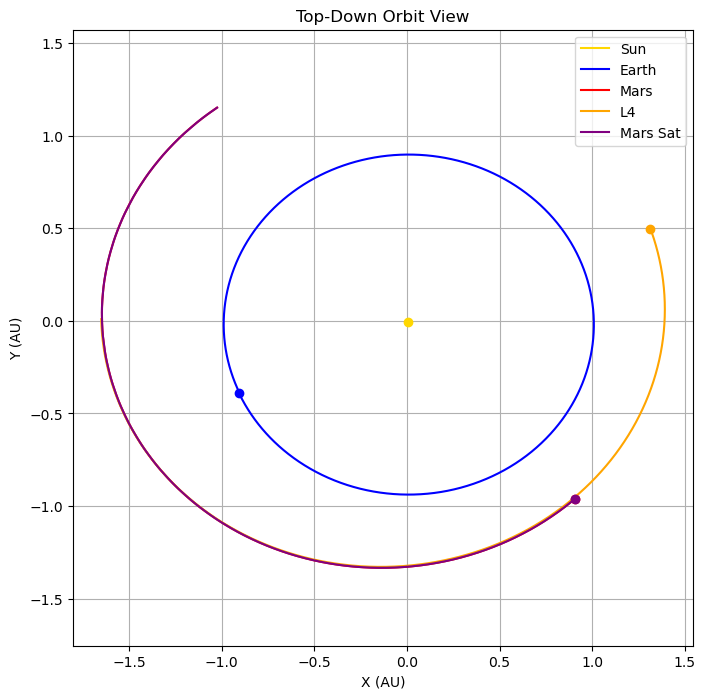

In [ ]:
def plot_orbits(objects, labels=None, colors=None, title="Top-Down Orbit View"):
    """
    Plots the top-down view of orbiting objects in 2D.

    Parameters:
    - objects: list of lists of (x, y) tuples representing positions in AU
    - labels: list of labels for each object
    - colors: list of colors for each object
    - title: plot title
    """
    fig, ax = plt.subplots(figsize=(8, 8))

    for i, orbit in enumerate(objects):
        x_vals = [pos[0] for pos in orbit]
        y_vals = [pos[1] for pos in orbit]

        label = labels[i] if labels and i < len(labels) else f"Object {i+1}"
        color = colors[i] if colors and i < len(colors) else None

        ax.plot(x_vals, y_vals, label=label, color=color)
        ax.plot(x_vals[-1], y_vals[-1], 'o', color=color)  

    ax.set_title(title)
    ax.set_xlabel("X (AU)")
    ax.set_ylabel("Y (AU)")
    ax.set_aspect('equal', adjustable='datalim')
    ax.grid(True)
    ax.legend()
    plt.show()


km_per_au = 1.495978707e8
sat_mars_position_au = np.array(Mars_sat_position) / km_per_au
mars_heliocentric = np.array(Mars_position)
sat_heliocentric_au = mars_heliocentric + sat_mars_position_au

plot_orbits(
    objects=[Sun_position, Earth_position, Mars_position, L4_sat_position, sat_heliocentric_au],
    labels=["Sun", "Earth", "Mars", "L4", "Mars Sat"],
    colors=["gold", "blue", "red", "orange", "purple"]
)


# Animate the Mars, Earth, and relay satellite trajectories and communication links

In [ ]:
def animate_orbits_to_mp4(objects, labels=None, colors=None, title="Link Paths", interval=50,
                        filename="orbit_animation.mp4", fps=30,
                        start_date="2038-04-15-00-00-00", end_date="2039-04-15-00-00-00", radio_paths=None):
    """
    Animates and saves a 2D orbit plot as an MP4 video.

    Parameters:
    - objects: list of lists of (x, y) positions over time in AU
    - labels: names of each object
    - colors: colors for each object
    - title: title of plot
    - interval: delay between frames in ms
    - filename: name of the output MP4 file
    - fps: frames per second in output video
    """
    num_frames = len(objects[0])  
    num_objects = len(objects)

    start_dt = datetime.strptime(start_date, "%Y-%m-%d-%H-%M-%S")
    end_dt = datetime.strptime(end_date, "%Y-%m-%d-%H-%M-%S")
    total_duration = end_dt - start_dt
    delta_per_frame = total_duration / num_frames

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_title(title)
    ax.set_xlabel("X (AU)")
    ax.set_ylabel("Y (AU)")
    ax.set_aspect('equal')
    ax.set_xlim(-2,2)
    ax.set_ylim(-2,2)
    ax.grid(True)

    lines = []
    points = []

    path_lines = []  
    label_to_index = {label: i for i, label in enumerate(labels)}


    for i in range(num_objects):
        color = colors[i] if colors else None
        label = labels[i] if labels else f"Object {i+1}"
        line, = ax.plot([], [], color=color, label=label)
        point, = ax.plot([], [], 'o', color=color)
        lines.append(line)
        points.append(point)

 
    ax.plot([], [], linestyle='--', color='forestgreen', linewidth=1.2, label='Radio Link')
    ax.plot([], [], linestyle='--', color='red', linewidth=1.2, label='Optical Link')

    ax.legend()

    def init():
        for line, point in zip(lines, points):
            line.set_data([], [])
            point.set_data([], [])
        return lines + points

    def update(frame):

        for i in range(num_objects):
            x_vals = [pos[0] for pos in objects[i][:frame+1]]
            y_vals = [pos[1] for pos in objects[i][:frame+1]]
            lines[i].set_data(x_vals, y_vals)
            points[i].set_data([x_vals[-1]], [y_vals[-1]])

        
        for pl in path_lines:
            pl.remove()
        path_lines.clear()

        
        if radio_paths and frame < len(radio_paths):
            path_string = radio_paths[frame]
            if path_string != "No Path":
                nodes = [label.strip() for label in path_string.split('-')]
                for j in range(len(nodes) - 1):
                    start_label = nodes[j].strip()
                    end_label = nodes[j + 1].strip()

                    if start_label in label_to_index and end_label in label_to_index:
                        i_start = label_to_index[start_label]
                        i_end = label_to_index[end_label]
                        pos_start = objects[i_start][frame]
                        pos_end = objects[i_end][frame]

                        
                        path_string = radio_paths[frame]
                        if 'Mars - Earth' == path_string:
                            path_color = 'red'
                        elif 'Mars - L4 Sat - Earth' in path_string:
                            path_color = 'forestgreen'
                        elif 'Mars - Mars Sat - L4 Sat - Earth' in path_string:
                            path_color = 'forestgreen'
                        elif 'Mars - Mars Sat - Earth' in path_string:
                            path_color = 'forestgreen'
                        else:
                            path_color = 'black'

                        line = ax.plot(
                            [pos_start[0], pos_end[0]],
                            [pos_start[1], pos_end[1]],
                            color=path_color,
                            linestyle='--',
                            linewidth=1.2,
                            alpha=0.7,
                            zorder=5
                        )[0]

                        path_lines.append(line) 

        
        current_date = start_dt + frame * delta_per_frame
        ax.set_title(f"{title} – Date: {current_date.strftime('%Y-%m-%d %H:%M:%S')}")

        return lines + points

    ani = FuncAnimation(fig, update, frames=num_frames, init_func=init, blit=True, interval=interval)

    
    writer = FFMpegWriter(fps=fps, metadata=dict(artist='HannahSperanza'), bitrate=1800)
    ani.save(filename, writer=writer)
    plt.close(fig)
    print(f"Animation saved to: {filename}")

animate_orbits_to_mp4(
    objects=[Sun_position, Earth_position, sat_heliocentric_au, L4_sat_position, Mars_position],
    labels=["Sun", "Earth", "Mars Sat", "L4 Sat", "Mars"],
    colors=["gold", "blue", "purple", "orange", "peru"],
    radio_paths=radio_paths,  
    filename="orbit_with_radio_paths.mp4"
)


Animation saved to: orbit_with_radio_paths.mp4


# Plot Mars, Earth, and relay satellite trajectories and commication link at specific date

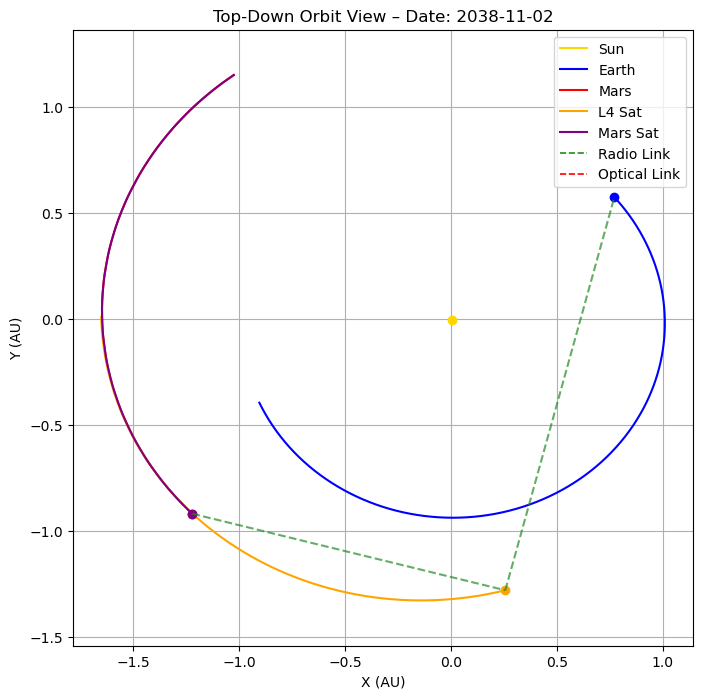

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def plot_orbits_static_up_to_date(objects, labels=None, colors=None,
                                   title="Top-Down Orbit View", mater_date="2038-10-01-00-00-00",
                                   start_date="2038-04-15-00-00-00", end_date="2039-04-15-00-00-00",
                                   radio_paths=None):
    """
    Static plot of orbiting objects from start_date up to mater_date, including radio link paths.

    Parameters:
    - objects: list of lists of (x, y) positions over time in AU
    - labels: list of object names
    - colors: list of plot colors
    - title: plot title
    - mater_date: date to visualize (YYYY-MM-DD-HH-MM-SS)
    - start_date, end_date: range of simulation
    - radio_paths: list of path strings (e.g., "Mars - Earth")
    """
    num_frames = len(objects[0])
    start_dt = datetime.strptime(start_date, "%Y-%m-%d-%H-%M-%S")
    end_dt = datetime.strptime(end_date, "%Y-%m-%d-%H-%M-%S")
    total_duration = end_dt - start_dt
    delta_per_frame = total_duration / num_frames

    mater_dt = datetime.strptime(mater_date, "%Y-%m-%d-%H-%M-%S")
    frame = int((mater_dt - start_dt) / delta_per_frame)
    frame = max(0, min(frame, num_frames - 1))  # clamp

    fig, ax = plt.subplots(figsize=(8, 8))
    label_to_index = {label: i for i, label in enumerate(labels)} if labels else {}

    for i, orbit in enumerate(objects):
        x_vals = [pos[0] for pos in orbit[:frame+1]]
        y_vals = [pos[1] for pos in orbit[:frame+1]]
        label = labels[i] if labels and i < len(labels) else f"Object {i+1}"
        color = colors[i] if colors and i < len(colors) else None
        ax.plot(x_vals, y_vals, label=label, color=color)
        ax.plot(x_vals[-1], y_vals[-1], 'o', color=color)

    if radio_paths and frame < len(radio_paths):
        path_string = radio_paths[frame]
        if path_string != "No Path":
            nodes = [label.strip() for label in path_string.split('-')]

            for j in range(len(nodes) - 1):
                start_label = nodes[j]
                end_label = nodes[j + 1]

                if start_label in label_to_index and end_label in label_to_index:
                    i_start = label_to_index[start_label]
                    i_end = label_to_index[end_label]
                    pos_start = objects[i_start][frame]
                    pos_end = objects[i_end][frame]

                    if path_string == 'Mars - Earth':
                        path_color = 'red'
                    elif 'L4 Sat' in path_string:
                        path_color = 'forestgreen'
                    else:
                        path_color = 'black'

                    ax.plot(
                        [pos_start[0], pos_end[0]],
                        [pos_start[1], pos_end[1]],
                        linestyle='--',
                        linewidth=1.5,
                        color=path_color,
                        alpha=0.7,
                        zorder=5
                    )

    ax.set_title(f"{title} – Date: {mater_dt.strftime('%Y-%m-%d')}")
    ax.set_xlabel("X (AU)")
    ax.set_ylabel("Y (AU)")
    ax.set_aspect('equal', adjustable='datalim')
    ax.grid(True)

    ax.plot([], [], linestyle='--', color='forestgreen', linewidth=1.2, label='Radio Link')
    ax.plot([], [], linestyle='--', color='red', linewidth=1.2, label='Optical Link')
    ax.legend()
    plt.show()

plot_orbits_static_up_to_date(
    objects=[Sun_position, Earth_position, Mars_position, L4_sat_position, sat_heliocentric_au],
    labels=["Sun", "Earth", "Mars", "L4 Sat", "Mars Sat"],
    colors=["gold", "blue", "red", "orange", "purple"],
    mater_date="2038-11-02-00-00-00",
    radio_paths=radio_paths  
)


# Plot Mars, Earth, and relay satellite trajectories and commication link at specific date with zoom and rotation

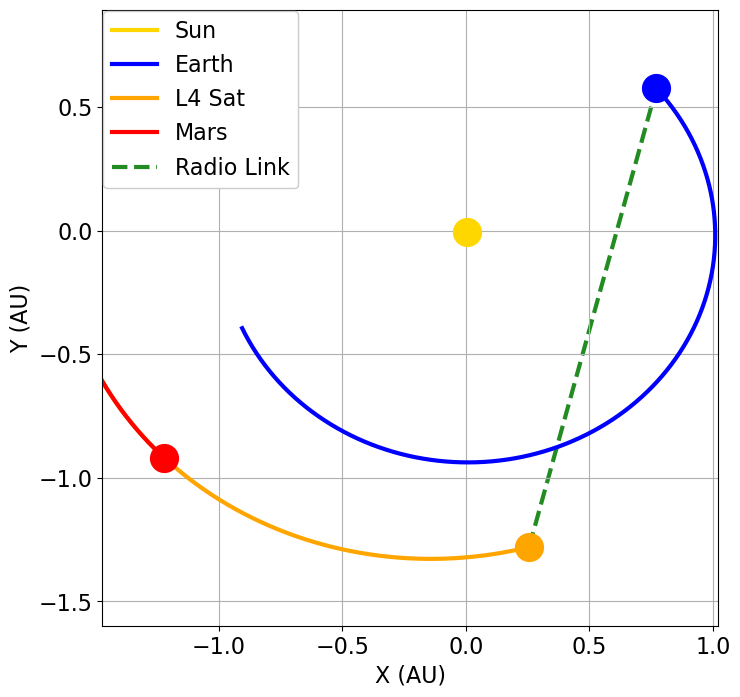

In [ ]:
def plot_orbits_static_zoomed(objects, labels=None, colors=None,
                               title="Top-Down Orbit View", mater_date="2038-10-01-00-00-00",
                               start_date="2038-04-15-00-00-00", end_date="2039-04-15-00-00-00",
                               radio_paths=None, rotation_deg=0):
    """
    Plots orbits up to mater_date, with tight zoom around current positions and optional rotation.

    Parameters:
    - objects: list of list of (x, y) positions over time in AU
    - labels, colors: metadata for objects
    - title: plot title
    - mater_date: date to evaluate current positions
    - start_date, end_date: sim range
    - radio_paths: link path strings
    - rotation_deg: optional rotation of frame (in degrees)
    """
    plt.rcParams.update({'font.size': 16})

    num_frames = len(objects[0])
    start_dt = datetime.strptime(start_date, "%Y-%m-%d-%H-%M-%S")
    end_dt = datetime.strptime(end_date, "%Y-%m-%d-%H-%M-%S")
    total_duration = end_dt - start_dt
    delta_per_frame = total_duration / num_frames

    mater_dt = datetime.strptime(mater_date, "%Y-%m-%d-%H-%M-%S")
    frame = int((mater_dt - start_dt) / delta_per_frame)
    frame = max(0, min(frame, num_frames - 1))

    theta = np.deg2rad(rotation_deg)
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

    fig, ax = plt.subplots(figsize=(15, 8))
    label_to_index = {label: i for i, label in enumerate(labels)} if labels else {}

    current_positions = []

    for i, orbit in enumerate(objects):
        orbit_trunc = np.array(orbit[:frame+1])[:, :2] 

        orbit_rot = orbit_trunc @ R.T  

        color = colors[i] if colors and i < len(colors) else None
        label = labels[i] if labels and i < len(labels) else f"Object {i+1}"

        ax.plot(orbit_rot[:, 0], orbit_rot[:, 1], label=label, color=color,linewidth=3)
        ax.plot(orbit_rot[-1, 0], orbit_rot[-1, 1], 'o', color=color, markersize=20)

        current_positions.append(orbit_rot[-1])

    if radio_paths and frame < len(radio_paths):
        path_string = radio_paths[frame]
        if path_string != "No Path":
            nodes = [label.strip() for label in path_string.split('-')]
            for j in range(len(nodes) - 1):
                start_label = nodes[j]
                end_label = nodes[j + 1]

                if start_label in label_to_index and end_label in label_to_index:
                    i_start = label_to_index[start_label]
                    i_end = label_to_index[end_label]
                    pos_start = np.array(objects[i_start][frame])[:2] @ R.T
                    pos_end   = np.array(objects[i_end][frame])[:2] @ R.T

                    if path_string == 'Mars - Earth':
                        path_color = 'red'
                    elif 'L4 Sat' in path_string:
                        path_color = 'forestgreen'
                    else:
                        path_color = 'black'

                    ax.plot(
                        [pos_start[0], pos_end[0]],
                        [pos_start[1], pos_end[1]],
                        linestyle='--',
                        linewidth=3,
                        color=path_color,
                        alpha=1,
                        zorder=0
                    )
    
    current_positions = np.array(current_positions)
    x_min, x_max = np.min(current_positions[:, 0]), np.max(current_positions[:, 0])
    y_min, y_max = np.min(current_positions[:, 1]), np.max(current_positions[:, 1])

    x_center = 0.5 * (x_max + x_min)
    y_center = 0.5 * (y_max + y_min)
    half_range = max(x_max - x_min, y_max - y_min) * 0.5 + 0.25  # small margin

    ax.set_xlim(x_center - half_range, x_center + half_range)
    ax.set_ylim(y_center - half_range, y_center + half_range)

    ax.set_xlabel("X (AU)")
    ax.set_ylabel("Y (AU)")
    ax.set_aspect('equal')
    ax.grid(True)

    ax.plot([], [], linestyle='--', color='forestgreen', linewidth=3, label='Radio Link')
    ax.legend(loc="upper left", bbox_to_anchor=(-.016, 1.016), facecolor='white', framealpha=1.0)
    plt.show()

plot_orbits_static_zoomed(
    objects=[Sun_position, Earth_position, L4_sat_position, Mars_position],
    labels=["Sun", "Earth", "L4 Sat", "Mars"],
    colors=["gold", "blue", "orange", "red"],
    mater_date="2038-11-02-00-00-00",
    radio_paths=radio_paths,
    rotation_deg=0  
)

# Animate Mars-orbit relay satellite around Mars

In [11]:
def Mars3DOrbit(
    Mars_position, Earth_position, Sun_position, L4_sat_position, Mars_sat_position,
    start_date="2038-04-15-00-00-00", end_date="2039-04-15-00-00-00",
    title="Animated Mars Orbit with Vectors", scale=1e5,
    filename="mars_orbit_animation.mp4", fps=30, radio_paths=None):
    def normalize_vector(v, target_length):
        norm = np.linalg.norm(v)
        return (v / norm) * target_length if norm != 0 else v
    AU_to_km = 1.496e+8
    Mars_position_np = np.array(Mars_position)
    Earth_position_np = np.array(Earth_position)
    Sun_position_np = np.array(Sun_position)
    L4_sat_position_np = np.array(L4_sat_position)
    Mars_sat_position_np = np.array(Mars_sat_position)
    mars_radius = 3396.2  # km
    num_frames = len(Mars_position_np)
    start_dt = datetime.strptime(start_date, "%Y-%m-%d-%H-%M-%S")
    end_dt = datetime.strptime(end_date, "%Y-%m-%d-%H-%M-%S")
    total_duration = end_dt - start_dt
    delta_per_frame = total_duration / num_frames
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    u, v = np.linspace(0, 2*np.pi, 30), np.linspace(0, np.pi, 30)
    xm = mars_radius * np.outer(np.cos(u), np.sin(v))
    ym = mars_radius * np.outer(np.sin(u), np.sin(v))
    zm = mars_radius * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(xm, ym, zm, color='lightblue', alpha=0.5)
    ax.quiver(0, 0, 0, 0, 0, 0, color='blue', label='Earth')
    ax.quiver(0, 0, 0, 0, 0, 0, color='gold', label='Sun')
    ax.quiver(0, 0, 0, 0, 0, 0, color='orange', label='L4 Sat')
    ax.scatter([0], [0], [0], color='peru', s=100, label='Mars Center')
    path_line, = ax.plot([], [], [], color='purple', linewidth=1, label='Orbital Path')
    head_dot, = ax.plot([], [], [], 'o', color='purple', markersize=6, label='Mars Relay')
    ax.legend(bbox_to_anchor=(1, 1))
    ax.set_xlabel("X (km)", labelpad=10)
    ax.set_ylabel("Y (km)", labelpad=10)
    ax.set_zlabel("Z (km)", labelpad=10)
    ax.set_box_aspect([1, 1, 1])
    def sci_notation(x, pos): return f"{x:.1e}"
    ax.xaxis.set_major_formatter(FuncFormatter(sci_notation))
    ax.yaxis.set_major_formatter(FuncFormatter(sci_notation))
    ax.zaxis.set_major_formatter(FuncFormatter(sci_notation))
    max_range = np.max(np.ptp(Mars_sat_position_np, axis=0))
    mid = np.mean(Mars_sat_position_np, axis=0)
    ax.set_xlim(-max_range, max_range)
    ax.set_ylim(-max_range, max_range)
    ax.set_zlim(-max_range, max_range)
    vector_objs = {'earth': None, 'sun': None, 'sat': None}
    radio_lines = []
    path_label = ax.text2D(0.05, 0.95, "", transform=ax.transAxes, fontsize=9)
    def update(frame):
        nonlocal vector_objs
        current_date = start_dt + frame * delta_per_frame
        mars_pos = Mars_position_np[frame]
        current = Mars_sat_position_np[frame] - mars_pos
        trail = Mars_sat_position_np[:frame + 1] - mars_pos
        path_line.set_data(trail[:, 0], trail[:, 1])
        path_line.set_3d_properties(trail[:, 2])
        head_dot.set_data([current[0]], [current[1]])
        head_dot.set_3d_properties([current[2]])
        vec_earth = normalize_vector(Earth_position_np[frame] - mars_pos, scale)
        vec_sun = normalize_vector(Sun_position_np[frame] - mars_pos, scale)
        vec_l4 = normalize_vector(L4_sat_position_np[frame] - mars_pos, scale)
        for key in vector_objs:
            if vector_objs[key]:
                vector_objs[key].remove()
        vector_objs['earth'] = ax.quiver(0, 0, 0, *vec_earth, color='blue')
        vector_objs['sun'] = ax.quiver(0, 0, 0, *vec_sun, color='gold')
        vector_objs['sat'] = ax.quiver(0, 0, 0, *vec_l4, color='orange')
        path_label.set_text(f"Path: {radio_paths[frame]}" if radio_paths and frame < len(radio_paths) else "")
        ax.set_title(f"{title} – Date: {current_date.strftime('%Y-%m-%d %H:%M:%S')}")
        return path_line, head_dot, path_label, *radio_lines
    ani = FuncAnimation(fig, update, frames=num_frames, interval=1, blit=False)
    writer = FFMpegWriter(fps=fps, metadata=dict(artist='HannahSperanza'), bitrate=1800)
    ani.save(filename, writer=writer)
    plt.tight_layout()
    plt.close(fig)
    print(f"Saved 3D Mars orbit animation to: {filename}")

Mars3DOrbit(
    Mars_position=Mars_position,
    Earth_position=Earth_position,
    Sun_position=Sun_position,
    L4_sat_position=L4_sat_position,
    Mars_sat_position=Mars_sat_position,
    title="Mars Satellite Orbit",
    filename="Relay Satellite Orbit.mp4",
    radio_paths=radio_paths
)


Saved 3D Mars orbit animation to: Relay Satellite Orbit.mp4


# Plot average daily communication data rate and power consumption over the mission

C:\Users\bochs2\AppData\Local\Temp\ipykernel_9580\2261143782.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


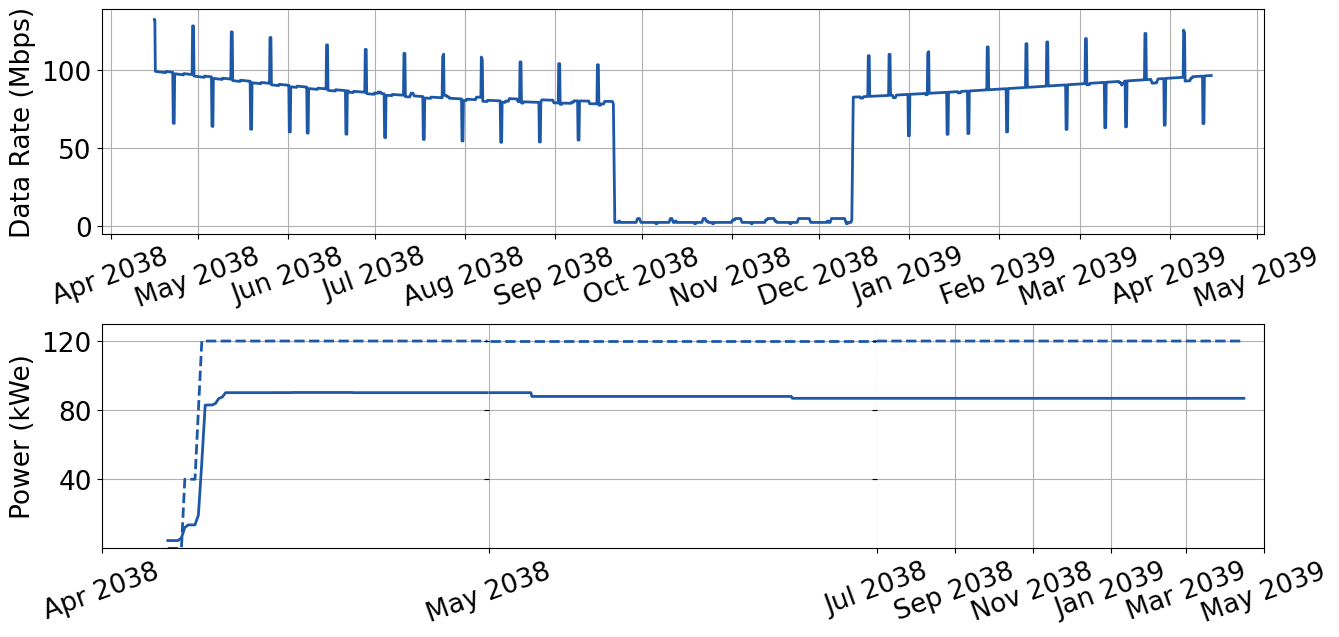

The average data rate is 68.58427715606912 Mbps
The connection percentage is 75.35371976266545 %
Max power draw 90.22439999999997


In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from datetime import datetime, timedelta
import numpy as np

plt.rcParams.update({'font.size': 19})

radioNumbers = []
connection = []
for i in range(len(radio_paths)):
    path_string = radio_paths[i]
    if 'Mars - Earth' in path_string:
        data = distance_to_data(optical_comm_link_up[i])
        radioNumbers.append(data)
        connection.append(1)
    elif 'Mars - L4 Sat - Earth' in path_string or \
         'Mars - Mars Sat - L4 Sat - Earth' in path_string or \
         'Mars - Mars Sat - Earth' in path_string:
        radioNumbers.append(5)
        connection.append(1)
    else:
        radioNumbers.append(0)
        connection.append(0)

start_date = "2038-04-15-06-00-00"
end_date = "2039-04-15-06-00-00"
start_dt = datetime.strptime(start_date, "%Y-%m-%d-%H-%M-%S")
end_dt = datetime.strptime(end_date, "%Y-%m-%d-%H-%M-%S")
time_labels = [start_dt + timedelta(seconds=i*time_step) for i in range(len(radioNumbers))]

window_size = int(86400 / time_step)
radioNumbers_array = np.array(radioNumbers)
moving_avg = np.convolve(radioNumbers_array, np.ones(window_size)/window_size, mode='valid')
avg_time_labels = time_labels[window_size - 1:]

range1 = (datetime(2038, 4, 12), datetime(2038, 5, 1))
range2 = (datetime(2038, 5, 1), datetime(2038, 7, 1))
range3 = (datetime(2038, 7, 2), datetime(2039, 5, 1))
time_labels_power = [start_dt + timedelta(seconds=i*time_step) for i in range(len(power_used))]

mask1 = [(t >= range1[0]) and (t <= range1[1]) for t in time_labels_power]
mask2 = [(t >= range2[0]) and (t <= range2[1]) for t in time_labels_power]
mask3 = [(t >= range3[0]) and (t <= range3[1]) for t in time_labels_power]

fig = plt.figure(figsize=(15, 7))
gs = GridSpec(2, 3, height_ratios=[1, 1], hspace=0.4, wspace=0)

ax_top = fig.add_subplot(gs[0, :])
ax_top.plot(avg_time_labels, moving_avg, linewidth=2, color="#1d58a7")
ax_top.set_ylabel('Data Rate (Mbps)')
ax_top.xaxis.set_major_locator(mdates.MonthLocator())
ax_top.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax_top.tick_params(axis='x', rotation=20)
ax_top.grid(True)

ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1], sharey=ax1)
ax3 = fig.add_subplot(gs[1, 2], sharey=ax1)

ax1.plot(np.array(time_labels_power)[mask1], np.array(power_used)[mask1]/time_step, linewidth=2, color="#1d58a7")
ax1.plot(np.array(time_labels_power)[mask1], np.array(power_generate)[mask1]/time_step, linewidth=2, color="#1d58a7", linestyle="--")
ax1.set_xlim(range1)
ax1.set_xticks([datetime(2038, 4, 12)])
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax1.tick_params(axis='x', rotation=20)

for ax, mask, date_range in zip([ax2, ax3], [mask2, mask3], [range2, range3]):
    ax.plot(np.array(time_labels_power)[mask], np.array(power_used)[mask]/time_step, linewidth=2, color="#1d58a7")
    ax.plot(np.array(time_labels_power)[mask], np.array(power_generate)[mask]/time_step, linewidth=2, color="#1d58a7", linestyle="--")
    ax.set_xlim(date_range)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.tick_params(axis='x', rotation=20)

for ax in [ax1, ax2, ax3]:
    ax.set_yticks([40, 80, 120])
    ax.set_ylim(0, 130)
    ax.grid(True)

ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax2.tick_params(labelleft=False)
ax3.tick_params(labelleft=False)

ax1.set_ylabel("Power (kWe)")

plt.tight_layout()
plt.show()

print(f"The average data rate is {np.average(radioNumbers)} Mbps")
print(f"The connection percentage is {100*np.average(connection)} %")
print(f"Max power draw {max(np.array(power_used)/time_step)}")
